In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
#import string
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xarray as xr

import torch
import torch.nn as nn
import joblib

In [2]:
pot_id = "100pct_3day-removed"
pot_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{pot_id}_outputs"

x_id = "x-cond-3day"
x_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{x_id}_outputs"

y_id = "y-cond-3day"
y_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{y_id}_outputs"

xy_id = 'xy-cond-3day'
xy_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{xy_id}_outputs"

In [3]:
class MonteCarloDropout(nn.Dropout):
    def forward(self, input):
        return nn.functional.dropout(input, self.p, True, self.inplace)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2056),
            nn.ReLU(),
            #MonteCarloDropout(0.2),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            #MonteCarloDropout(0.2), 
	        nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            MonteCarloDropout(0.2), 
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [4]:
model_pot = MLP(10)
model_pot.load_state_dict(torch.load(f'{pot_path}/model_{pot_id}.pt'))
model_pot.eval()

model_x = MLP(10)
model_x.load_state_dict(torch.load(f'{x_path}/model_{x_id}.pt'))
model_x.eval()

model_y = MLP(10)
model_y.load_state_dict(torch.load(f'{y_path}/model_{y_id}.pt'))
model_y.eval()

model_xy = MLP(10)
model_xy.load_state_dict(torch.load(f'{xy_path}/model_{xy_id}.pt'))
model_xy.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=2056, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2056, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): MonteCarloDropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [6]:
#Load omni data
omni_data = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_5min_1999-10.csv')
omni_data = omni_data[omni_data['Timestamp_1min_omni'] == '1999-10-01 00:00:00']
#omni_data = omni_data[omni_data['Timestamp_1min_omni'].between('1999-10-01 00:00:00', '1999-10-01 11:55:00')]
omni_data

,BY_GSE,BZ_GSE,flow_speed,proton_density,AE_INDEX,AL_INDEX,AU_INDEX,Timestamp_1min_omni,Timestamp_1hr_omni,F10.7,Kp,tilt_angle
0,1.84,0.66,485.0,4.17,178,-100,79,1999-10-01 00:00:00,1999-10-01 00:00:00,121.900002,23,-0.115365


In [7]:
def split_to_df(df):

    df = df.copy()

    #filters
    df = df[df['BY_GSE'] < 100]
    df = df[df['BZ_GSE'] < 100]
    df = df[df['flow_speed'] < 1400]
    df = df[df['proton_density'] < 150]
    df = df[df['F10.7'] < 400]
    df = df[df['Kp'] < 100]
    df['Kp'] = df['Kp'] / 10

    #change data types
    df[['F10.7','flow_speed']] = df[['F10.7','flow_speed']].astype(int)

    #create grid of lat and lon
    lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
    lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

    lat_mesh, lon_mesh = np.meshgrid(lat, lon)
    lats = lat_mesh.flatten()
    lons = lon_mesh.flatten()

    #expand out df to lat and lon dims. Aka repeat values 
    expanded_df = pd.DataFrame({'lat': lats.repeat(len(df)), 
                                'lon': lons.repeat(len(df)),
                                'BY_GSE': np.tile(df['BY_GSE'], len(lat)*len(lon)),
                                'BZ_GSE': np.tile(df['BZ_GSE'], len(lat)*len(lon)),
                                'flow_speed': np.tile(df['flow_speed'], len(lat)*len(lon)),
                                'proton_density': np.tile(df['proton_density'], len(lat)*len(lon)),
                                'tilt_angle': np.tile(df['tilt_angle'], len(lat)*len(lon)),
                                'dt': np.tile(df['Timestamp_1min_omni'], len(lat)*len(lon)),
                                'F10.7': np.tile(df['F10.7'], len(lat)*len(lon)),
                                'Kp': np.tile(df['Kp'], len(lat)*len(lon)),
                                'AE_INDEX': np.tile(df['AE_INDEX'], len(lat)*len(lon)),
                                'AL_INDEX': np.tile(df['AL_INDEX'], len(lat)*len(lon)),
                                'AU_INDEX': np.tile(df['AU_INDEX'], len(lat)*len(lon))})

    expanded_df['mlt'] = np.mod(expanded_df['lon'] + 12, 360) / 15


    df_2 = expanded_df.copy()
    df_2 = df_2[['dt','mlt','lon','lat','BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]

    df_2['mlt_sin'] = np.sin(df_2['mlt']*(2.*np.pi/24))
    df_2['mlt_cos'] = np.cos(df_2['mlt']*(2.*np.pi/24))

    df_2['lon_sin'] = np.sin((df_2['lon']-1)*(2.*np.pi/360))
    df_2['lon_cos'] = np.cos((df_2['lon']-1)*(2.*np.pi/360))

    df_2 = df_2.drop(columns=['dt'])

    return expanded_df, df_2

df_raw, df_proc = split_to_df(omni_data)
df_raw


,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,AE_INDEX,AL_INDEX,AU_INDEX,mlt
0,53.100000,1.6,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.906667
1,54.362069,1.6,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.906667
2,55.624138,1.6,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.906667
3,56.886207,1.6,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.906667
4,58.148276,1.6,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.906667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,84.651724,357.6,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.640000
2396,85.913793,357.6,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.640000
2397,87.175862,357.6,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.640000
2398,88.437931,357.6,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.640000


In [ ]:
'''
with open(f'{pot_path}/scaler_{pot_id}.pkl', 'rb') as f:
    scaler = pickle.load(f)

col_names = df_proc.columns
norm_arr = scaler.transform(df_proc)
df_proc = pd.DataFrame(norm_arr, columns=col_names)
df_proc = df_proc.drop(columns=['mlt','lon'])
df_proc'''

In [8]:
def rescale(df, path, id):

    df = df.copy()
    
    with open(f'{path}/scaler_{id}.pkl', 'rb') as f:
        scaler = pickle.load(f)

    col_names = df.columns
    norm_arr = scaler.transform(df)
    df = pd.DataFrame(norm_arr, columns=col_names)
    df = df.drop(columns=['mlt','lon'])
    
    return df

df_pot = rescale(df_proc, pot_path, pot_id)
df_x = rescale(df_proc, x_path, x_id)
df_y = rescale(df_proc, y_path, y_id)
df_xy = rescale(df_proc, xy_path, xy_id)

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [9]:
def make_predictions(df, model):

    df = df.copy()

    df = df.to_numpy()
    
    df = torch.tensor(df, dtype=torch.float32)

    batch_size = 10000  # Adjust this value based on your system's memory capacity
    n = len(df)
    predictions = []

    for i in range(0, n, batch_size):
        batch = df[i:i+batch_size]
        batch_pred = model(batch).detach().cpu().numpy()
        batch_pred = batch_pred.flatten()
        predictions.extend(batch_pred)

    return predictions

pot_pred = make_predictions(df_pot, model_pot)
x_pred = make_predictions(df_x, model_x)
y_pred = make_predictions(df_y, model_y)
xy_pred = make_predictions(df_xy, model_xy)

df_comp = df_raw
df_comp['pot_pred'] = pot_pred
df_comp['x_pred'] = x_pred
df_comp['y_pred'] = y_pred
df_comp['xy_pred'] = xy_pred

In [ ]:
'''
df_proc = df_proc.to_numpy()
df_proc = torch.tensor(df_proc, dtype=torch.float32)

batch_size = 10000  # Adjust this value based on your system's memory capacity
n = len(df_proc)
predictions = []

for i in range(0, n, batch_size):
    batch = df_proc[i:i+batch_size]
    batch_pred = model_pot(batch).detach().cpu().numpy()
    batch_pred = batch_pred.flatten()
    predictions.extend(batch_pred)

df_raw['potential_pred'] = predictions
df_comp = df_raw
df_comp'''

In [10]:
def filter_by_dt(df):
   df = df.copy()
   #df = df[df['dt']=='1999-10-01 12:00:00']
   
   df = df.sort_values(by=['lat'])
   df = df[df['lat'].between(60, 70)]

   return df

df_filt = filter_by_dt(df_comp)
df_filt

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,AE_INDEX,AL_INDEX,AU_INDEX,mlt,pot_pred,x_pred,y_pred,xy_pred
96,60.672414,15.118987,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,1.807932,-7.097184,4.479509,4.609331,14.934960
6,60.672414,1.600000,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.906667,-4.340323,4.728426,4.714456,15.999670
1536,60.672414,231.422785,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,16.228186,8.799278,4.258246,4.018061,6.797504
2346,60.672414,353.093671,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.339578,-0.459766,4.906984,5.074140,17.775841
1626,60.672414,244.941772,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,17.129451,10.474216,3.836583,3.495968,7.384122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,69.506897,19.625316,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,2.108354,-11.291367,1.658531,1.624136,1.619964
1033,69.506897,154.815190,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,11.121013,-7.654009,4.253806,4.559155,7.575085
1633,69.506897,244.941772,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,17.129451,27.824095,3.157795,3.796636,8.434223
2233,69.506897,335.068354,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,23.137890,8.976854,1.665008,1.624136,1.626081


In [11]:
df_filt['lat'].unique()

array([60.67241379, 61.93448276, 63.19655172, 64.45862069, 65.72068966,
       66.98275862, 68.24482759, 69.50689655])

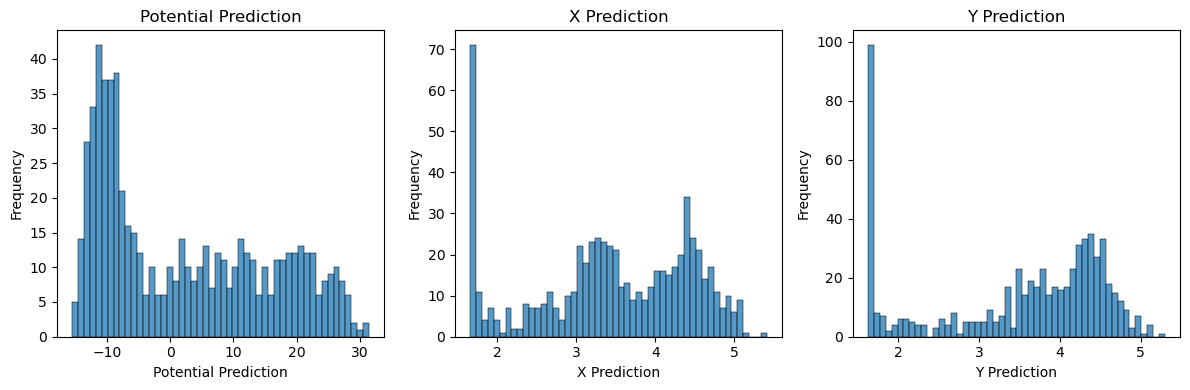

In [12]:
#plot pot_pred, x_pred, y_pred 
figs, axs = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(df_filt['pot_pred'], ax=axs[0], bins=50)
axs[0].set_title('Potential Prediction')
axs[0].set_xlabel('Potential Prediction')
axs[0].set_ylabel('Frequency')

sns.histplot(df_filt['x_pred'], ax=axs[1], bins=50)
axs[1].set_title('X Prediction')
axs[1].set_xlabel('X Prediction')
axs[1].set_ylabel('Frequency')

sns.histplot(df_filt['y_pred'], ax=axs[2], bins=50)
axs[2].set_title('Y Prediction')
axs[2].set_xlabel('Y Prediction')
axs[2].set_ylabel('Frequency')

plt.tight_layout()

Ua4RevqM

In [13]:
def calculate_delta(lat1, lon1, lat2, lon2):
    R_E = 6371.0 * 1e3 #meters

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    delta_x = (dlat / 360)*2*np.pi*R_E
    delta_y = (dlon / 360)*2*np.pi*R_E*np.sin(lat1_rad)

    return delta_x, delta_y

lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

delta_x, delta_y = calculate_delta(lat[0], lon[0], lat[1], lon[1])


In [16]:
dx, dy, = delta_x, delta_y
df_filt['delta_x'] = dx
df_filt['delta_y'] = dy

for dt in df_filt['dt'].unique():
    df_dt = df_filt[df_filt['dt'] == dt]
    #dx, dy = calculate_gradient(df_dt['lat'].values, df_dt['lon'].values)
    grad_x, grad_y = np.gradient(df_dt['pot_pred'].values.reshape(8,80), dx, dy) #8 values is for between 60 and 70 lat, otherwise its 30
    grad_x = grad_x.flatten()
    grad_y = grad_y.flatten()
    Ex = -grad_x * 1e3 #mV/m
    Ey = -grad_y * 1e3 #mV/m

    df_filt.loc[df_filt['dt'] == dt, 'Ex'] = Ex
    df_filt.loc[df_filt['dt'] == dt, 'Ey'] = Ey

#df_filt['Vx'] = df_filt['Ex'] * 40
#df_filt['Vy'] = df_filt['Ey'] * 40
df_filt['dt'] = pd.to_datetime(df_filt['dt'])
df_filt = df_filt.sort_values(by=['dt'])
df_filt

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,...,AU_INDEX,mlt,pot_pred,x_pred,y_pred,xy_pred,Ex,Ey,delta_x,delta_y
96,60.672414,15.118987,1.84,0.66,485,4.17,-0.115365,1999-10-01,121,2.3,...,79,1.807932,-7.097184,4.479509,4.609331,14.934960,-1.048416,-4.636544,2449.31943,6993.651888
1536,60.672414,231.422785,1.84,0.66,485,4.17,-0.115365,1999-10-01,121,2.3,...,79,16.228186,8.799278,4.258246,4.018061,6.797504,-2.597430,-0.277434,2449.31943,6993.651888
2346,60.672414,353.093671,1.84,0.66,485,4.17,-0.115365,1999-10-01,121,2.3,...,79,0.339578,-0.459766,4.906984,5.074140,17.775841,2.666040,-0.119747,2449.31943,6993.651888
1626,60.672414,244.941772,1.84,0.66,485,4.17,-0.115365,1999-10-01,121,2.3,...,79,17.129451,10.474216,3.836583,3.495968,7.384122,-3.022408,0.447186,2449.31943,6993.651888
996,60.672414,150.308861,1.84,0.66,485,4.17,-0.115365,1999-10-01,121,2.3,...,79,10.820591,-6.714690,4.724244,4.765020,4.982964,0.504535,1.216610,2449.31943,6993.651888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,69.506897,154.815190,1.84,0.66,485,4.17,-0.115365,1999-10-01,121,2.3,...,79,11.121013,-7.654009,4.253806,4.559155,7.575085,0.793225,-2.796498,2449.31943,6993.651888
1633,69.506897,244.941772,1.84,0.66,485,4.17,-0.115365,1999-10-01,121,2.3,...,79,17.129451,27.824095,3.157795,3.796636,8.434223,-7.326657,-1.561878,2449.31943,6993.651888
1393,69.506897,208.891139,1.84,0.66,485,4.17,-0.115365,1999-10-01,121,2.3,...,79,14.726076,14.192448,4.473554,4.583697,8.254291,3.950786,2.993730,2449.31943,6993.651888
2233,69.506897,335.068354,1.84,0.66,485,4.17,-0.115365,1999-10-01,121,2.3,...,79,23.137890,8.976854,1.665008,1.624136,1.626081,-7.499856,-2.584992,2449.31943,6993.651888


In [91]:
#Ex = -grad_x
#Ey = -grad_y

#df_filt['Ex'] = Ex.flatten() #north-south
#df_filt['Ey'] = Ey.flatten()  #east-west

#calculate conductivity tensor
#df_filt['sigma_xy'] = df_filt['x_pred'] * df_filt['y_pred']
#df_filt['sigma_xx'] = df_filt['x_pred']**2
#df_filt['sigma_yy'] = df_filt['y_pred']**2
#df_filt['sigma_neg_xy'] = -df_filt['x_pred'] * df_filt['y_pred']

#calculate Hall and Pedersen currents
df_filt['JHx'] = -df_filt['xy_pred'] * df_filt['Ey'] #east-west
df_filt['JHy'] = df_filt['xy_pred'] * df_filt['Ex'] #north-south

#Pederson currents and Joule Heating
#df_filt['JPx'] = df_filt['x_pred'] * df_filt['Ex']
#df_filt['JPy'] = df_filt['y_pred'] * df_filt['Ey']
#df_filt['QJx'] = df_filt['JPx'] * df_filt['Ex']**2
#df_filt['QJy'] = df_filt['JPy'] * df_filt['Ey']**2

df_filt['dt'] = pd.to_datetime(df_filt['dt'])
df_filt

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,...,AU_INDEX,mlt,pot_pred,x_pred,y_pred,xy_pred,Ex,Ey,JHx,JHy
19476723,69.506897,330.562025,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,...,79,22.837468,14.042258,1.659569,1.624116,1.626781,-2.696335,-2.273142,3.697904,-4.386346
4623843,69.506897,78.207595,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,...,79,6.013840,-12.224998,2.648910,2.442817,5.605511,4.875033,1.048602,-5.877950,27.327049
16293963,69.506897,276.486076,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,...,79,19.232405,29.828287,2.211324,2.392183,6.119629,-0.821295,-2.230355,13.648944,-5.026021
618870,65.720690,10.612658,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,...,79,1.507511,-10.998397,1.777008,1.627324,1.842358,-0.632620,1.140027,-2.100339,-1.165514
1441083,69.506897,24.131646,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,...,79,2.408776,-13.433166,1.661968,1.624136,1.629885,12.534552,1.436190,-2.340825,20.429880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18398120,65.720690,312.536709,-5.69,-2.22,443,10.68,-0.310287,1999-10-31 23:55:00,158,3.0,...,127,21.635781,3.209719,3.477759,3.034580,4.674837,3.339149,-0.446930,2.089323,15.609976
9919601,66.982759,168.334177,-5.69,-2.22,443,10.68,-0.310287,1999-10-31 23:55:00,158,3.0,...,127,12.022278,-0.235068,2.267754,2.209458,3.269045,-1.247030,0.674734,-2.205735,-4.076598
9619007,61.934483,163.827848,-5.69,-2.22,443,10.68,-0.310287,1999-10-31 23:55:00,158,3.0,...,127,11.721857,-0.669705,3.146276,2.121653,2.583298,-0.065955,0.478219,-1.235383,-0.170380
2749550,65.720690,46.663291,-5.69,-2.22,443,10.68,-0.310287,1999-10-31 23:55:00,158,3.0,...,127,3.910886,-8.108682,3.663834,3.343306,4.925437,-0.424835,-0.021139,0.104118,-2.092500


In [92]:
#take maximum value of JHx for each dt and call it JHx_max and the minimum value of JHx for each dt and call it JHx_min. add to new d

df_AU = df_filt.groupby('dt')['AU_INDEX'].mean().reset_index()
df_AU.columns = ['dt','AU_INDEX']

df_AL = df_filt.groupby('dt')['AL_INDEX'].mean().reset_index()
df_AL.columns = ['dt','AL_INDEX']

df_JHy_max = df_filt.groupby('dt')['JHy'].max().reset_index()
df_JHy_max.columns = ['dt','JHy_AU']

df_JHy_min = df_filt.groupby('dt')['JHy'].min().reset_index()
df_JHy_min.columns = ['dt','JHy_AL']

df_ae = pd.merge(df_JHy_max, df_JHy_min, on='dt')
df_ae = pd.merge(df_ae, df_AU, on='dt')
df_ae = pd.merge(df_ae, df_AL, on='dt')
df_ae['JHy_AE'] = df_ae['JHy_AU'] - df_ae['JHy_AL']
df_ae['AE_INDEX'] = df_ae['AU_INDEX'] - df_ae['AL_INDEX']   
df_ae


,dt,JHy_AU,JHy_AL,AU_INDEX,AL_INDEX,JHy_AE,AE_INDEX
0,1999-10-01 00:00:00,207.679062,-180.273239,79.0,-100.0,387.952301,179.0
1,1999-10-01 00:05:00,158.443863,-163.915466,71.0,-107.0,322.359314,178.0
2,1999-10-01 00:10:00,138.002899,-143.708221,78.0,-100.0,281.711121,178.0
3,1999-10-01 00:15:00,62.722210,-61.429348,80.0,-89.0,124.151558,169.0
4,1999-10-01 00:20:00,46.301071,-54.018379,76.0,-151.0,100.319450,227.0
...,...,...,...,...,...,...,...
8836,1999-10-31 23:35:00,65.653961,-86.615067,133.0,-136.0,152.269028,269.0
8837,1999-10-31 23:40:00,57.942108,-82.463303,117.0,-159.0,140.405411,276.0
8838,1999-10-31 23:45:00,50.033154,-53.863781,122.0,-225.0,103.896935,347.0
8839,1999-10-31 23:50:00,54.575409,-48.853821,124.0,-213.0,103.429230,337.0


In [103]:
ae_rmse = np.sqrt(np.mean((df_ae['JHy_AE'] - df_ae['AE_INDEX'])**2))
ae_nrmse = ae_rmse / (df_ae['AE_INDEX'].max() - df_ae['AE_INDEX'].min())
ae_R = np.corrcoef(df_ae['JHy_AE'], df_ae['AE_INDEX'])[0,1]

print(f'RMSE: {ae_rmse}')
print(f'NRMSE: {ae_nrmse}')
print(f'R: {ae_R}')

RMSE: 252.40261511285618
NRMSE: 0.16086846087498802
R: 0.35555283532905674


In [129]:
au_rmse = np.sqrt(np.mean((df_ae['JHy_AU'] - df_ae['AU_INDEX'])**2))
au_nrmse = au_rmse / (df_ae['AU_INDEX'].max() - df_ae['AU_INDEX'].min())
au_R = np.corrcoef(df_ae['JHy_AU'], df_ae['AU_INDEX'])[0,1]

al_rmse = np.sqrt(np.mean((df_ae['JHy_AL'] - df_ae['AL_INDEX'])**2))
al_nrmse = al_rmse / (df_ae['AL_INDEX'].max() - df_ae['AL_INDEX'].min())
al_R = np.corrcoef(df_ae['JHy_AL'], df_ae['AL_INDEX'])[0,1]

print(f'RMSE: {au_rmse}')
print(f'NRMSE: {au_nrmse}')
print(f'R: {au_R}')

print(f'RMSE: {al_rmse}')
print(f'NRMSE: {al_nrmse}')
print(f'R: {al_R}')

RMSE: 97.39870789975349
NRMSE: 0.14690604509766741
R: 0.2189928444824949
RMSE: 203.7869523364601
NRMSE: 0.12897908375725323
R: 0.3569033943241619


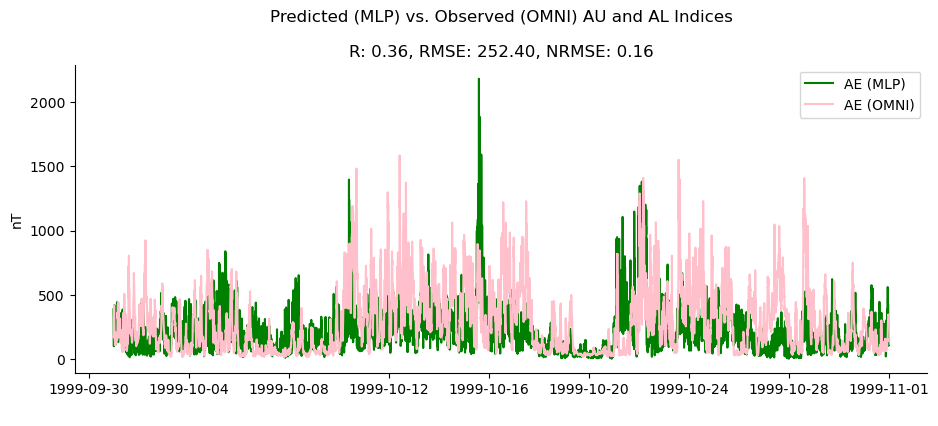

In [131]:
fig, ax = plt.subplots(figsize=(11, 4))

#sns.lineplot(df_ae, x='dt', y='JHy_AU', color='red', label='AU (MLP)')
#sns.lineplot(df_ae, x='dt', y='AU_INDEX', color='orange', label='AU (OMNI)')
sns.lineplot(df_ae, x='dt', y='JHy_AE', color='green', label='AE (MLP)')

#sns.lineplot(df_ae, x='dt', y='JHy_AL', color='blue', label='AL (MLP)')
#sns.lineplot(df_ae, x='dt', y='AL_INDEX', color='purple', label='AL (OMNI)')
sns.lineplot(df_ae, x='dt', y='AE_INDEX', color='pink', label='AE (OMNI)')

#x ticks to be every 7 days
ax.set_xlabel(' ')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('nT')
#ax.set_ylim(-1650, 1500)
ax.set_title(f'Predicted (MLP) vs. Observed (OMNI) AU and AL Indices\n\nR: {ae_R:.2f}, RMSE: {ae_rmse:.2f}, NRMSE: {ae_nrmse:.2f}')

#remove upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

<Axes: xlabel='QJx', ylabel='Count'>

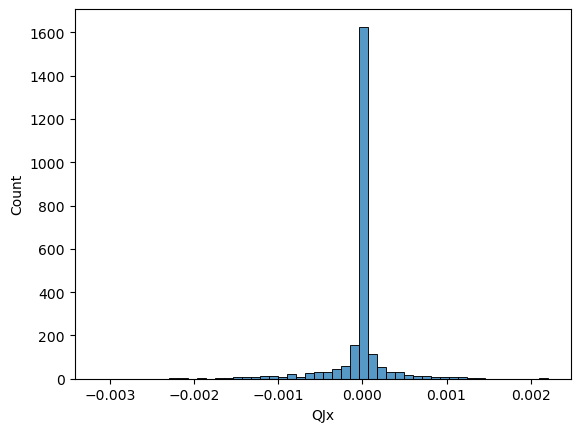

In [154]:
sns.histplot(df_filt['QJx']*1e-6, bins=50)

/tmp/ipykernel_6939/89148617.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<xarray.Dataset> Size: 298kB
Dimensions:         (dt: 1, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) object 8B '1999-10-01 00:00:00'
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables: (12/20)
    BY_GSE          (dt, lat, lon) float64 19kB 1.84 1.84 1.84 ... 1.84 1.84
    BZ_GSE          (dt, lat, lon) float64 19kB 0.66 0.66 0.66 ... 0.66 0.66
    flow_speed      (dt, lat, lon) int64 19kB 485 485 485 485 ... 485 485 485
    proton_density  (dt, lat, lon) float64 19kB 4.17 4.17 4.17 ... 4.17 4.17
    tilt_angle      (dt, lat, lon) float64 19kB -0.1154 -0.1154 ... -0.1154
    F10.7           (dt, lat, lon) int64 19kB 121 121 121 121 ... 121 121 121
    ...              ...
    Ex              (dt, lat, lon) float32 10kB 1.0 1.77 4.591 ... 2.273 -4.096
    Ey              (dt, lat, lon) float32 10kB 0.05137 0.0147 ... -0.0615
    JPx             (dt, lat, lon) float32 10kB 1.793 3.153 ... 3.682 -6.754
    JPy             (dt, lat, lon) float32 10kB 0.08334 0.02385 ... -0.09988
    QJx             (dt, lat, lon) float32 10kB 1.794 9.884 ... 19.02 -113.3
    QJy             (dt, lat, lon) float32 10kB 0.0002199 ... -0.0003778

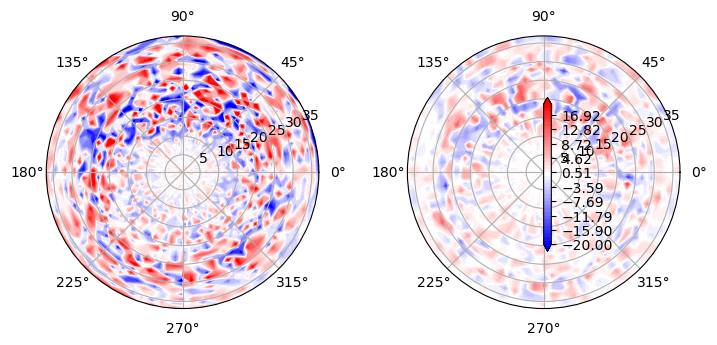

In [164]:
def polar_plot(df):
    df = df.copy()
    df = df.set_index(['dt','lat','lon'])
    ds = df.to_xarray()

    theta = np.linspace(0, 360, 80) - 90
    theta_rad = theta / 360 * 2 * np.pi
    r = 90 - np.linspace(53.1, 89.7, 30)
    shrink = .5

    fig, ax = plt.subplots(1, 2, figsize=(7, 4), subplot_kw={'projection': 'polar'})

    Qjx = (ds['JPx'].mean('dt').values)
    Qjy = (ds['JPy'].mean('dt').values)

    levels = np.linspace(-20, 20, 40)
    plot = ax[0].contourf(theta_rad, r, Qjx, cmap='bwr', levels=levels, extend='both')
    #ax[0].set_title('Joule Heating East-West')

    plot = ax[1].contourf(theta_rad, r, Qjy, cmap='bwr', levels=levels, extend='both')
    #ax[1].set_title('Joule Heating North-South')

    plt.colorbar(plot, ax=ax, shrink=shrink)
    plt.tight_layout()



    return ds

polar_plot(df_filt)

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,...,Ex,Ey,JPx,JPy,QJx,QJy,theta,r,Er,Etheta
0,53.1,1.600000,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,...,1.000376,0.051366,1.792532,0.083337,1.793880,0.000220,0.027925,36.9,1.001420,0.023414
30,53.1,6.106329,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,...,1.770481,0.014701,3.153182,0.023851,9.883972,0.000005,0.106576,36.9,1.761999,-0.173716
60,53.1,10.612658,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,...,4.590725,-0.514264,8.194351,-0.834363,172.693939,-0.220662,0.185226,36.9,4.417488,-1.350935
90,53.1,15.118987,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,...,-4.577713,-0.366210,-8.158067,-0.594653,-170.956009,-0.079749,0.263876,36.9,-4.514778,0.840445
120,53.1,19.625316,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,...,0.773034,1.433933,1.376832,2.326510,0.822769,4.783688,0.342526,36.9,1.209740,1.090998


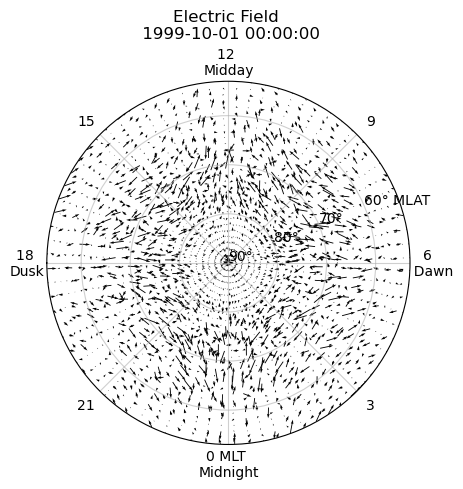

In [208]:
def plot_quiver(df):
    df = df.copy()
    df = df.sort_values(by=['lat','lon'])

    df['theta'] = np.radians(df['lon'])
    df['r'] = 90 - df['lat']

    df['Er'] = df['Ex'] * np.cos(df['theta']) + df['Ey'] * np.sin(df['theta'])
    df['Etheta'] = -df['Ex'] * np.sin(df['theta']) + df['Ey'] * np.cos(df['theta'])

    fig, ax = plt.subplots(1, 1, figsize=(5, 5),subplot_kw={'projection': 'polar'})

    ax.quiver(df['theta'], df['r'], df['Er'], df['Etheta'],scale=200)
    #ax.set_title('Electric Field')

    ax.set_ylim([0, 37])
    ax.set_yticks([0, 10, 20, 30])
    ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    ax.set_xlim([-np.pi, np.pi])
    ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 \nMidday", "15", "18 \nDusk"])
    ax.set_title(f'Electric Field \n 1999-10-01 00:00:00')
    #plt.colorbar(c_true, ax=ax, label='Potential (Error) [kV]', shrink=shrink, pad=0.15, ticks=np.arange(0,6,1), orientation='horizontal')
    ax.grid(True, linestyle='-', alpha=0.6)
    #ax.set_theta_direction(-1)

    plt.tight_layout()
    plt.savefig('quiver.png',dpi=300)


    return df.head(5)

plot_quiver(df_filt)